# Sad songs<a name="top"></a>

This is a replication of the [fitteR happieR](http://rcharlie.com/2017-02-16-fitteR-happieR/) post which attempted to find the most depressing Radiohead song.

I've redone it here, using tools available in TM351.

## Contents
* [Analysis](#analysis)
* [Sentiment](#sentiment)
* [Gloom index](#gloomindex)
* [Revised gloom index](#revisedgloomindex)
* [Contrasting songs](#valencenegcontrast)
* [Gloom per album](#gloomperalbum)
* [Complexity per album](#complexityovertime)

### [Conclusion](#conclusion)

In [250]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import urllib.request
import urllib.parse
import urllib.error
import json
import base64
import configparser
from bs4 import BeautifulSoup
import re
import pymongo
from datetime import datetime
import time
import collections
import editdistance
import math
from scipy.spatial import ConvexHull
from pandas.plotting import scatter_matrix

We'll use MongoDB to store the data, to save keeping it all in memory, and mean we don't have to recapture all the data to to a different analysis.

In [251]:
# Open a connection to the Mongo server
client = pymongo.MongoClient('mongodb://localhost:27017/')

In [252]:
# Create a database and a collections within it.
songs_db = client.songs
albums = songs_db.albums
unfiltered_tracks = songs_db.tracks
genius_tracks = songs_db.gtracks

In [253]:
interesting_pipe = [{'$match':{'ignore': {'$exists': False}}}]

In [254]:
songs_db.collection_names()

['system.views',
 'gtracks',
 'system.indexes',
 'sentiments',
 'albums',
 'tracks',
 'interesting_tracks']

In [255]:
# interesting_pipeline = 
# db.runCommand( { create: <view>, viewOn: <source>, pipeline: <pipeline> } )
# songs_db.create_collection('interesting_tracks', viewOn=songs_db.tracks, pipeline=interesting_pipe)
if 'interesting_tracks' not in songs_db.collection_names():
    songs_db.command("create", "interesting_tracks",
        viewOn='tracks', 
        pipeline=interesting_pipe)

In [256]:
tracks = songs_db.interesting_tracks

API keys and the like are kept in a configuration file, which is read here.

You'll need to create a web API key for Spotify and Genius. 

In [257]:
config = configparser.ConfigParser()
config.read('secrets.ini')
[k for k in config['genius']]

['app_name', 'client_id', 'client_secret', 'redirect_uri', 'token']

In [258]:
## How to write the config file. Fill in the details, and create a different config section for Spotify.
# config['genius'] = {}
# config['genius']['app_name'] = 'xxx'
# config['genius']['client_id'] = 'xxx'
# config['genius']['client_secret'] = 'xxx'
# config['genius']['token'] = 'xxx'
# with open('secrets.ini', 'w') as configfile:
#     config.write(configfile)

In [259]:
stones_id = '22bE4uQ6baNwSHPVcDxLCe'
beatles_id = '3WrFJ7ztbogyGnTHbHJFl2'
radiohead_id = '4Z8W4fKeB5YxbusRsdQVPb'

In [260]:
# radiohead_id = albums.find_one({'artist_name': 'Radiohead'})['artist_id']
# radiohead_id

In [261]:
# beatles_id = albums.find_one({'artist_name': 'The Beatles'})['artist_id']
# beatles_id

In [262]:
# stones_id = albums.find_one({'artist_name': 'The Rolling Stones'})['artist_id']
# stones_id

# Analysis<a name="analysis"></a>
Finally, we can get to the analysis of the data!

First, what are the lowest-valence songs, and what's the distribution of valences?

* [Top](#top)

In [263]:
pd.DataFrame(list(tracks.find({}, 
                              ['artist_name', 'name', 'valence'], 
                              sort=[('valence', pymongo.ASCENDING)], limit=20)))

,_id,artist_name,name,valence
0,1CEZV1nYaEeqhWz73HKF3g,The Rolling Stones,Intro - Live,0.0263
1,1AVrv7FD10FoKW38oBiKRg,Radiohead,Bloom (Blawan Rmx),0.0327
2,4rkGGQEqxHIXVJ4oXjOHgF,George Martin,Sea Of Holes - Remastered,0.0357
3,0ttMfoND7IQqFSMVOPkELC,The Beatles,Blue Jay Way - Remastered 2009,0.0378
4,53RYTfkLiyZuUZHwJC3Wmm,Radiohead,We Suck Young Blood,0.0378
5,01ZpFhrMMqKPVCwyqXneVp,Radiohead,True Love Waits,0.0379
6,66Pyms4pYaHEcPHZ7DdMbE,Radiohead,TKOL (Altrice Rmx),0.0382
7,3gKuywOm38axM8sJGq6Laq,Radiohead,MK 1,0.0389
8,2uYSbsxAMmK1awUl06T7ix,Radiohead,MK 2,0.0390
9,75YUnz58ajMo2VIIuUFvOV,Radiohead,The Tourist,0.0398


Just the Beatles songs.

In [264]:
beatles_df = pd.DataFrame(list(tracks.find({'artist_id': beatles_id}, 
                              ['artist_name', 'name', 'valence'])))
beatles_df.sort_values('valence').head(10)

,_id,artist_name,name,valence
80,0ttMfoND7IQqFSMVOPkELC,The Beatles,Blue Jay Way - Remastered 2009,0.0378
114,0agoaPIy92gPZ6zRhqXarE,The Beatles,Tomorrow Never Knows - Remastered,0.0534
76,6ZrPbHp9kRmQj1tGLvna8U,The Beatles,Revolution 9 - Remastered,0.1010
219,3ZFPe2aiLQuEfDxSqQstZp,The Beatles,A Day In The Life - Remix,0.1330
206,1Spno7RVP9d3wszxojPJXZ,The Beatles,Penny Lane - Take 6 / Instrumental,0.1470
0,2ucFulEWapRAmTn7l6f5Q7,The Beatles,Wild Honey Pie - Remastered,0.1520
33,4cLoL5KPfE1hAwfsO84FX7,The Beatles,Because - Remastered,0.1620
71,27YZJHyTTDIurMqDu1v2ef,The Beatles,"Long, Long, Long - Remastered",0.1630
100,3ZFBeIyP41HhnALjxWy1pR,The Beatles,A Day In The Life - Remastered,0.1750
77,2tf8ljpWPmXNIFgRVhEuJg,The Beatles,Good Night - Remastered,0.1780


And plot the valences..

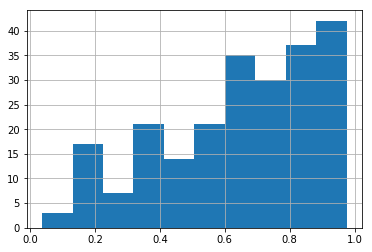

In [265]:
beatles_df['valence'].hist()

In [266]:
stones_df = pd.DataFrame(list(tracks.find({'artist_id': stones_id}, 
                              ['artist_name', 'name', 'valence'])))
stones_df.sort_values('valence').head(10)

,_id,artist_name,name,valence
194,1CEZV1nYaEeqhWz73HKF3g,The Rolling Stones,Intro - Live,0.0263
280,4EllMMamxvLvwvOQLsyc9W,The Rolling Stones,Brown Sugar - Live,0.1030
14,1tEdH58k6r4CvjEhmxxbMC,The Rolling Stones,Jumpin’ Jack Flash - Live,0.1200
70,1dTX9ivyAhFJLR1f2pk9Kv,The Rolling Stones,Out Of Tears - Remastered,0.1370
139,388ll2SEjDO9LZIXXyKtjh,The Rolling Stones,Little Rain,0.1570
203,1tiyUANzZamsPZlHhZBbOd,The Rolling Stones,You Can’t Always Get What You Want - Live,0.1600
61,1Wfdb6cNBPdpoZYniHfL7o,The Rolling Stones,Always Suffering - Remastered,0.1610
253,4HjKfesqhmkthgJg738g3A,The Rolling Stones,Connection - Live,0.1610
242,0q26ITWa4vXhoV5jvRCZXZ,The Rolling Stones,It's All Over Now - Live,0.1650
64,1qEGxs60ntxuenj27BnRkF,The Rolling Stones,How Can I Stop - Remastered,0.1670


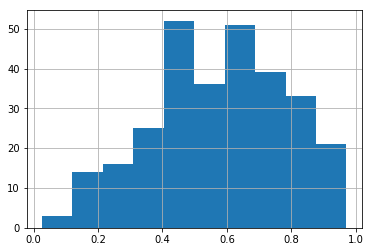

In [267]:
stones_df['valence'].hist()

In [268]:
radiohead_df = pd.DataFrame(list(tracks.find({'artist_id': radiohead_id}, 
                              ['artist_name', 'name', 'valence'])))
radiohead_df.sort_values('valence').head(10)

,_id,artist_name,name,valence
14,1AVrv7FD10FoKW38oBiKRg,Radiohead,Bloom (Blawan Rmx),0.0327
76,53RYTfkLiyZuUZHwJC3Wmm,Radiohead,We Suck Young Blood,0.0378
50,01ZpFhrMMqKPVCwyqXneVp,Radiohead,True Love Waits,0.0379
13,66Pyms4pYaHEcPHZ7DdMbE,Radiohead,TKOL (Altrice Rmx),0.0382
20,3gKuywOm38axM8sJGq6Laq,Radiohead,MK 1,0.0389
21,2uYSbsxAMmK1awUl06T7ix,Radiohead,MK 2,0.0390
113,75YUnz58ajMo2VIIuUFvOV,Radiohead,The Tourist,0.0398
101,0COiZ7ncho2yi4HotbzgPv,Radiohead,Motion Picture Soundtrack,0.0435
15,0tKuiKb2mazZYdA6fPP7kI,Radiohead,Good Evening Mrs Magpie (Modeselektor RMX),0.0438
62,4gq2bc2770XvbJdEtfUbmw,Radiohead,Go Slowly,0.0439


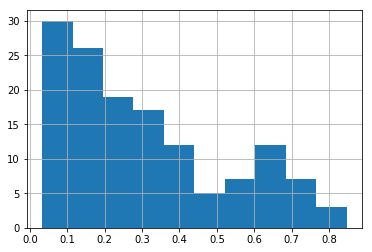

In [269]:
radiohead_df['valence'].hist()

And now plot both on the same chart, to clearly show that Radiohead songs are generally lower-valence than The Beatles.

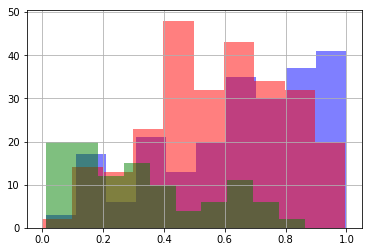

In [370]:
beatles_df['valence'].hist(alpha=0.5, color='blue')
stones_df['valence'].hist(alpha=0.5, color='red')
radiohead_df['valence'].hist(alpha=0.5, color='green')

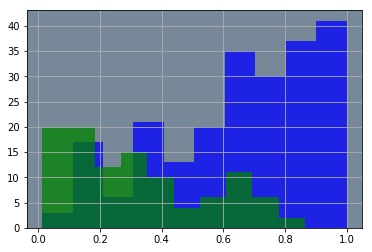

In [377]:
ax = beatles_df['valence'].hist(alpha=0.75, color='blue')
radiohead_df['valence'].hist(alpha=0.75, color='green')
ax.set_facecolor("lightslategray")

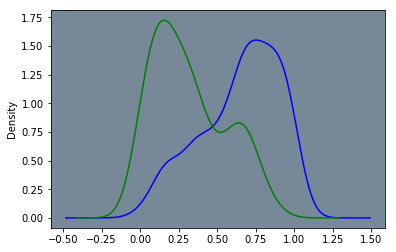

In [376]:
ax = beatles_df['valence'].plot.kde(color='blue')
radiohead_df['valence'].plot.kde(color='green')
ax.set_facecolor("lightslategray")

### Sentiment<a name="sentiment"></a>
We can now look at the sentiment scores for the lyrics. We start by looking at the most negative songs for each artist.

* [Top](#top)

In [271]:
pipeline = [
    {'$match': {'lyrics': {'$exists': True}, 'sentiment': {'$exists': True}, 'valence': {'$exists': True},
               'artist_id': beatles_id}},
    {'$project': {'artist_name': '$artist_name',
                  'name': '$name',
                  'valence': '$valence',
                  'neg': '$sentiment.probability.neg',
                  'neutral': '$sentiment.probability.neutral',
                  'pos': '$sentiment.probability.pos'}}
]
beatles_df = pd.DataFrame(list(tracks.aggregate(pipeline)))
beatles_df.sort_values('neg', ascending=False).head(10)

,_id,artist_name,name,neg,neutral,pos,valence
54,3VgxeWOGdUYvtX1j8C9VyV,The Beatles,I'm So Tired - Remastered,0.892489,0.146302,0.107511,0.717
28,6gLmFcRwyQCQT23Df2Re9G,The Beatles,I Want You (She's So Heavy) - Remastered,0.880760,0.091819,0.119240,0.420
73,6ZrPbHp9kRmQj1tGLvna8U,The Beatles,Revolution 9 - Remastered,0.872056,0.172322,0.127944,0.101
152,3EbGioQyKyf4dycuiPOg3k,The Beatles,Everybody's Trying To Be My Baby - Remastered,0.866985,0.914332,0.133015,0.943
19,4311wT21Et0q3vepFwXjTu,The Beatles,One After 909 - Remastered,0.865737,0.158470,0.134263,0.888
114,3QbhVaulXxTyuAxHY3Pa5N,The Beatles,You Won't See Me - Remastered,0.864585,0.247226,0.135415,0.473
161,3Aqo28W4LLAolYpN3duVJl,The Beatles,I'll Cry Instead - Remastered,0.863772,0.160516,0.136228,0.960
58,3OSi8ehmSWLTD5KatlzX8r,The Beatles,Don't Pass Me By - Remastered,0.857831,0.120676,0.142169,0.946
100,3wAOX1N5M0ta3QNsokmhJV,The Beatles,I'm Only Sleeping - Remastered,0.857651,0.269800,0.142349,0.698
138,1e0hllQ23AG0QGFgezgLOq,The Beatles,Yesterday - Remastered,0.852156,0.132796,0.147844,0.315


In [272]:
pipeline = [
    {'$match': {'lyrics': {'$exists': True}, 'sentiment': {'$exists': True}, 'valence': {'$exists': True},
               'artist_id': stones_id}},
    {'$project': {'artist_name': '$artist_name',
                  'name': '$name',
                  'valence': '$valence',
                  'neg': '$sentiment.probability.neg',
                  'neutral': '$sentiment.probability.neutral',
                  'pos': '$sentiment.probability.pos'}}
]
stones_df = pd.DataFrame(list(tracks.aggregate(pipeline)))
stones_df.sort_values('neg', ascending=False).head(10)

,_id,artist_name,name,neg,neutral,pos,valence
51,6QPaiM2qBKKAYNd8WiSR7u,The Rolling Stones,You Got Me Rocking - Remastered,0.904388,0.202058,0.095612,0.653
146,2tBmA66b4cxYm7o2iPz0bO,The Rolling Stones,Cry To Me - Saturday Club / 1965,0.892635,0.161381,0.107365,0.848
27,4sLirGgpkyL3RSdr13q3wd,The Rolling Stones,She Saw Me Coming - Remastered,0.885088,0.121018,0.114912,0.854
34,2L5stllrpcxflppsrTKG2c,The Rolling Stones,Look What The Cat Dragged In - Remastered,0.883536,0.148691,0.116464,0.556
136,2OtFl6ryjvaH3dGiTUUeh9,The Rolling Stones,Come On - Saturday Club / 1963,0.882142,0.130341,0.117858,0.815
20,7DgRvvPcJlxks2lNpudsuT,The Rolling Stones,Petrol Blues,0.871627,0.259468,0.128373,0.447
61,3Bz8qzOdHrXlo9ySAqHy97,The Rolling Stones,Baby Break It Down - Remastered,0.866306,0.218643,0.133694,0.745
158,0VpHQIzxruwK61HgIkN4bs,The Rolling Stones,Everybody Needs Somebody To Love - Top Gear / ...,0.861867,0.113604,0.138133,0.465
233,1JZKBtBVhP5HmZLzMCcXFX,The Rolling Stones,Tumbling Dice - Live,0.856529,0.199091,0.143471,0.402
132,5XQ2enmXsgp66RvyolR8qC,The Rolling Stones,Tumbling Dice - Live,0.856529,0.199091,0.143471,0.607


In [273]:
pipeline = [
    {'$match': {'lyrics': {'$exists': True}, 'sentiment': {'$exists': True}, 'valence': {'$exists': True},
               'artist_id': radiohead_id}},
    {'$project': {'artist_name': '$artist_name',
                  'name': '$name',
                  'valence': '$valence',
                  'neg': '$sentiment.probability.neg',
                  'neutral': '$sentiment.probability.neutral',
                  'pos': '$sentiment.probability.pos'}}
]
radiohead_df = pd.DataFrame(list(tracks.aggregate(pipeline)))
radiohead_df.sort_values('neg', ascending=False).head(10)

,_id,artist_name,name,neg,neutral,pos,valence
101,11qDTSr3Dj4TkPnBcIOqEJ,Radiohead,Vegetable,0.883291,0.170371,0.116709,0.420
49,38WL6GlG9NHFiQS6JxV84r,Radiohead,Myxomatosis,0.864921,0.261355,0.135079,0.570
97,2zYmvi3w2T8a9Ckrv21bvW,Radiohead,Stop Whispering,0.855982,0.188600,0.144018,0.298
34,1w8QCSDH4QobcQeT4uMKLm,Radiohead,4 Minute Warning,0.854820,0.516574,0.145180,0.223
83,3aDUSpF3LexOr1lFKvPV2h,Radiohead,The Bends,0.854244,0.533823,0.145756,0.311
103,48IEDejXX5LH8TAC3VIGpc,Radiohead,I Can't,0.849730,0.265375,0.150270,0.276
75,3SVAN3BRByDmHOhKyIDxfC,Radiohead,Karma Police,0.846129,0.100438,0.153871,0.317
89,4dPKQxaraW6CG1rTBzV6DW,Radiohead,My Iron Lung,0.845080,0.190863,0.154920,0.671
24,5SdmtFbNOD7Qej6jFCHkOM,Radiohead,Faust Arp,0.838532,0.167778,0.161468,0.226
19,6dsq7Nt5mIFzvm5kIYNORy,Radiohead,15 Step,0.836356,0.160928,0.163644,0.847


Plot the valence/negativity scatter plot, using blue for The Beatles, red for The Rolling Stones, and green for Radiohead.

If valence and negativity are correlated, I'd expect to see a trend from high negativity/low valence to low negativity/high valence.

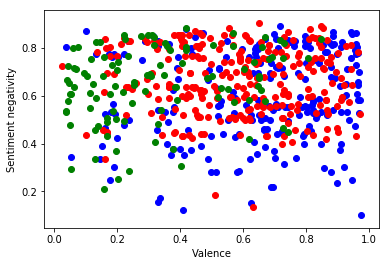

In [274]:
plt.scatter(beatles_df['valence'], beatles_df['neg'], color='blue')
plt.scatter(stones_df['valence'], stones_df['neg'], color='red')
plt.scatter(radiohead_df['valence'], radiohead_df['neg'], color='green')
plt.xlabel('Valence')
plt.ylabel('Sentiment negativity')
plt.show()

Neutrality, I think, is to do with the confidence in the classification.

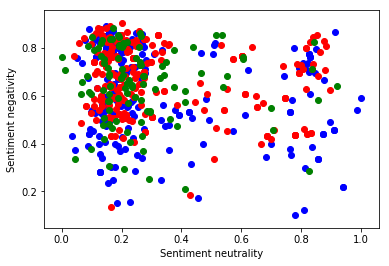

In [275]:
plt.scatter(beatles_df['neutral'], beatles_df['neg'], color='blue')
plt.scatter(stones_df['neutral'], stones_df['neg'], color='red')
plt.scatter(radiohead_df['neutral'], radiohead_df['neg'], color='green')
plt.xlabel('Sentiment neutrality')
plt.ylabel('Sentiment negativity')
plt.show()

This plot shows that most songs have a low neutrality, so express a clear sentiment in the lyrics. Let's plot the distribution of "neutral" scores to highlight this.

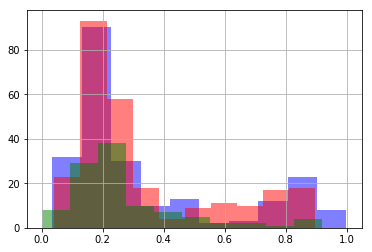

In [276]:
beatles_df['neutral'].hist(alpha=0.5, color='blue')
stones_df['neutral'].hist(alpha=0.5, color='red')
radiohead_df['neutral'].hist(alpha=0.5, color='green')

### Gloom index<a name="gloomindex"></a>
Let's recreate the "gloom index" idea from the original post and see what it tells us. Bear in mind that I'm using the sentiment negativity score, not the fraction of "sad" words.

* [Top](#top)

In [277]:
pipeline = [
    {'$match': {'lyrics': {'$exists': True}, 'sentiment': {'$exists': True}, 'valence': {'$exists': True}}},
    {'$project': {'artist_name': '$artist_name',
                  'name': '$name',
                  'valence': '$valence',
                  'neg': '$sentiment.probability.neg',
                  'lyrical_density': '$lyrical_density',
                  'gloom': {'$divide': [{'$add': [{'$subtract': [1, '$valence']},
                                                  {'$multiply': ['$sentiment.probability.neg', 
                                                                 {'$add': ['$lyrical_density', 1]}]}]}, 
                                        2]}}}]
results = pd.DataFrame(list(tracks.aggregate(pipeline)))
results.sort_values('gloom', ascending=False).head(20)

,_id,artist_name,gloom,lyrical_density,name,neg,valence
320,7DgRvvPcJlxks2lNpudsuT,The Rolling Stones,1.970165,2.886214,Petrol Blues,0.871627,0.4470
246,66cuLvkHsW7dNkfNk6gQP9,Radiohead,1.501762,1.991725,A Wolf At the Door,0.793363,0.3700
314,624njB7Ny3mlA46QokEin9,The Rolling Stones,1.498709,1.966968,No Spare Parts,0.855560,0.5410
195,2Iccm3cKBQHWt5yk0yX9nh,The Beatles,1.486236,2.192747,Please Please Me - Remastered 2009,0.838924,0.7060
476,0VpHQIzxruwK61HgIkN4bs,The Rolling Stones,1.458336,1.763389,Everybody Needs Somebody To Love - Top Gear / ...,0.861867,0.4650
458,4OXnLDjN5SClCcqTqPVMBy,The Rolling Stones,1.418133,2.156830,Cops And Robbers - Blues In Rhythm / 1964,0.707440,0.3970
454,2OtFl6ryjvaH3dGiTUUeh9,The Rolling Stones,1.412219,1.992080,Come On - Saturday Club / 1963,0.882142,0.8150
497,1CEZV1nYaEeqhWz73HKF3g,The Rolling Stones,1.406982,1.541667,Intro - Live,0.724038,0.0263
219,5SdmtFbNOD7Qej6jFCHkOM,Radiohead,1.397920,1.411166,Faust Arp,0.838532,0.2260
378,6ncZ7LP1NY4IOp2zQLPOPX,The Rolling Stones,1.366616,1.704903,Fight - Remastered,0.807878,0.4520


Interestingly, the gloomiest songs seem pretty evenly spread between artists.

In [278]:
pipeline = [
    {'$match': {'lyrics': {'$exists': True}, 'sentiment': {'$exists': True}, 'valence': {'$exists': True},
               'artist_id': radiohead_id}},
    {'$project': {'artist_name': '$artist_name',
                  'name': '$name',
                  'valence': '$valence',
                  'neg': '$sentiment.probability.neg',
                  'lyrical_density': '$lyrical_density',
                  'gloom': {'$divide': [{'$add': [{'$subtract': [1, '$valence']},
                                                  {'$multiply': ['$sentiment.probability.neg', 
                                                                 {'$add': ['$lyrical_density', 1]}]}]}, 
                                        2]}}}]
results = pd.DataFrame(list(tracks.aggregate(pipeline)))
results.sort_values('gloom', ascending=False).head(10)

,_id,artist_name,gloom,lyrical_density,name,neg,valence
51,66cuLvkHsW7dNkfNk6gQP9,Radiohead,1.501762,1.991725,A Wolf At the Door,0.793363,0.3700
24,5SdmtFbNOD7Qej6jFCHkOM,Radiohead,1.397920,1.411166,Faust Arp,0.838532,0.2260
83,3aDUSpF3LexOr1lFKvPV2h,Radiohead,1.241768,1.100731,The Bends,0.854244,0.3110
13,0eZN5WsQfmNFICHuw59Zfz,Radiohead,1.151552,0.705463,Glass Eyes,0.800195,0.0616
98,3ovbSnT5NNhl1gzMcw1NRZ,Radiohead,1.141115,1.151468,Thinking About You,0.791660,0.4210
85,045sp2JToyTaaKyXkGejPy,Radiohead,1.087313,0.581341,Fake Plastic Trees,0.827542,0.1340
84,5jafMI8FLibnjkYTZ33m0c,Radiohead,1.086242,0.858319,High And Dry,0.820356,0.3520
88,4SE81CrzH0qPA8KHqM9Syz,Radiohead,1.071914,0.856048,Just,0.809154,0.3580
74,4aOAzvRdOsZSwZIgwcdeL0,Radiohead,1.056868,0.524102,Let Down,0.825887,0.1450
102,4D6ZExVvYLZxhcAvifX5px,Radiohead,1.053547,0.749795,Prove Yourself,0.815006,0.3190


These, in theory, are the most depressing Radiohead songs. For information, the [fitteR happieR songs](http://rcharlie.com/2017-02-16-fitteR-happieR/) were:

  | gloom_index|               track_name
--|------------|--------------------------|
1 |        1.00 |           True Love Waits
2 |        6.46 |        Give Up The Ghost
3 |        9.35 | Motion Picture Soundtrack
4 |       13.70 |                 Let Down
5 |       14.15 |             Pyramid Song
6 |       14.57 |  Exit Music (For a Film)
7 |       15.29 |          Dollars & Cents
8 |       15.69 |              High And Dry
9 |       15.80 | Tinker Tailor Soldier ...
10|       16.03 |                Videotape

...which has only two songs in common, "High and Dry" and "Let Down". I'm not convinced by this analysis.

What does the same analysis say for The Beatles?

In [279]:
pipeline = [
    {'$match': {'lyrics': {'$exists': True}, 'sentiment': {'$exists': True}, 'valence': {'$exists': True},
               'artist_id': beatles_id}},
    {'$project': {'artist_name': '$artist_name',
                  'name': '$name',
                  'valence': '$valence',
                  'neg': '$sentiment.probability.neg',
                  'lyrical_density': '$lyrical_density',
                  'gloom': {'$divide': [{'$add': [{'$subtract': [1, '$valence']},
                                                  {'$multiply': ['$sentiment.probability.neg', 
                                                                 {'$add': ['$lyrical_density', 1]}]}]}, 
                                        2]}}}]
results = pd.DataFrame(list(tracks.aggregate(pipeline)))
results.sort_values('gloom', ascending=False).head(10)

,_id,artist_name,gloom,lyrical_density,name,neg,valence
186,2Iccm3cKBQHWt5yk0yX9nh,The Beatles,1.486236,2.192747,Please Please Me - Remastered 2009,0.838924,0.7060
54,3VgxeWOGdUYvtX1j8C9VyV,The Beatles,1.350197,1.708599,I'm So Tired - Remastered,0.892489,0.7170
73,6ZrPbHp9kRmQj1tGLvna8U,The Beatles,1.266826,0.874479,Revolution 9 - Remastered,0.872056,0.1010
39,5H9q6ctIlamkqukdTrNt3k,The Beatles,1.245539,2.616693,Her Majesty - Remastered,0.556608,0.5220
219,42uZOBjvKNv4QKnBmjOwb0,The Beatles,1.237099,1.234363,Getting Better - Take 1 / Instrumental And Spe...,0.807478,0.3300
126,5ou2BiQ9FxIYkxsYvYHpAT,The Beatles,1.209378,1.648037,Help! - Remastered,0.823915,0.7630
209,55kc3bnwWdGFCqthgjqR9l,The Beatles,1.205065,1.112515,She's Leaving Home - Remix,0.764553,0.2050
77,0ttMfoND7IQqFSMVOPkELC,The Beatles,1.203310,0.799772,Blue Jay Way - Remastered 2009,0.802557,0.0378
138,1e0hllQ23AG0QGFgezgLOq,The Beatles,1.195785,1.002650,Yesterday - Remastered,0.852156,0.3150
153,69d54YOS8TOQiUYjX57XeA,The Beatles,1.183494,1.601816,A Hard Day's Night - Remastered,0.831722,0.7970


In [280]:
pipeline = [
    {'$match': {'lyrics': {'$exists': True}, 'sentiment': {'$exists': True}, 'valence': {'$exists': True},
               'artist_id': stones_id}},
    {'$project': {'artist_name': '$artist_name',
                  'name': '$name',
                  'valence': '$valence',
                  'neg': '$sentiment.probability.neg',
                  'lyrical_density': '$lyrical_density',
                  'gloom': {'$divide': [{'$add': [{'$subtract': [1, '$valence']},
                                                  {'$multiply': ['$sentiment.probability.neg', 
                                                                 {'$add': ['$lyrical_density', 1]}]}]}, 
                                        2]}}}]
results = pd.DataFrame(list(tracks.aggregate(pipeline)))
results.sort_values('gloom', ascending=False).head(10)

,_id,artist_name,gloom,lyrical_density,name,neg,valence
20,7DgRvvPcJlxks2lNpudsuT,The Rolling Stones,1.970165,2.886214,Petrol Blues,0.871627,0.4470
14,624njB7Ny3mlA46QokEin9,The Rolling Stones,1.498709,1.966968,No Spare Parts,0.855560,0.5410
158,0VpHQIzxruwK61HgIkN4bs,The Rolling Stones,1.458336,1.763389,Everybody Needs Somebody To Love - Top Gear / ...,0.861867,0.4650
140,4OXnLDjN5SClCcqTqPVMBy,The Rolling Stones,1.418133,2.156830,Cops And Robbers - Blues In Rhythm / 1964,0.707440,0.3970
136,2OtFl6ryjvaH3dGiTUUeh9,The Rolling Stones,1.412219,1.992080,Come On - Saturday Club / 1963,0.882142,0.8150
165,1CEZV1nYaEeqhWz73HKF3g,The Rolling Stones,1.406982,1.541667,Intro - Live,0.724038,0.0263
78,6ncZ7LP1NY4IOp2zQLPOPX,The Rolling Stones,1.366616,1.704903,Fight - Remastered,0.807878,0.4520
248,1mnDusx7zn2yzmr42hUksE,The Rolling Stones,1.359143,1.496926,Rip This Joint - Live,0.767858,0.1990
209,20AK6SpqAq9naDPylmJOzT,The Rolling Stones,1.273183,1.606426,Rip This Joint - Live,0.767858,0.4550
30,4EBRAPYAcIczjUA4Z0BdhQ,The Rolling Stones,1.179917,1.199295,"Oh No, Not You Again - Remastered",0.843376,0.4950


### Revised gloom index<a name="revisedgloomindex"></a>
I don't like the calculation for gloom index. If the point of "lyrical density" is to scale the gloom index between valence and sentiment, depending on how many words are in the song. Let's do that weighting properly.

$$gloom = \frac{(1 - normedLyricDensity)\times(1 - valence) + normedLyricDensity \times negativity }{2}$$

* [Top](#top)

In [281]:
pipeline = [
    {'$match': {'lyrics': {'$exists': True}, 'sentiment': {'$exists': True}, 'valence': {'$exists': True}}},
    {'$project': {'artist_name': '$artist_name',
                  'name': '$name',
                  'valence': '$valence',
                  'neg': '$sentiment.probability.neg',
                  'lyrical_density': '$lyrical_density'}}]
results = pd.DataFrame(list(tracks.aggregate(pipeline)))

# Use pandas to scale the lyrical density values to the range 0 -1
results['scaled_ld'] = (results['lyrical_density'] - results['lyrical_density'].min()) / \
    (results['lyrical_density'].max() - results['lyrical_density'].min())

# Define a Python function to calculate the revised gloom index
def gloom(row):
    w_valence = (1 - row['valence']) * (1 - row['scaled_ld'])
    w_neg = row['neg'] * row['scaled_ld']
    return (w_valence + w_neg) / 2

# Apply this function to create a new column
results['gloom'] = results.apply(gloom, axis=1)

# Push the results back into the database
for row in results.itertuples():
    unfiltered_tracks.update_one({'_id': row[1]}, {'$set': {'gloom': row.gloom}})

results.sort_values('gloom', ascending=False).head(10)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom
225,4gq2bc2770XvbJdEtfUbmw,Radiohead,0.201546,Go Slowly,0.723774,0.0439,0.061262,0.470934
276,75YUnz58ajMo2VIIuUFvOV,Radiohead,0.248061,The Tourist,0.667864,0.0398,0.077527,0.468768
213,01ZpFhrMMqKPVCwyqXneVp,Radiohead,0.218723,True Love Waits,0.532206,0.0379,0.067268,0.466591
239,53RYTfkLiyZuUZHwJC3Wmm,Radiohead,0.276367,We Suck Young Blood,0.535358,0.0378,0.087425,0.462442
235,5olWalQH1oVza5D6xJg4oX,Radiohead,0.216752,Sail To The Moon,0.605798,0.0540,0.066579,0.461675
172,4sLGaMl33I6mcsk7u4xHAU,Radiohead,0.146307,Codex,0.637942,0.0648,0.041947,0.461365
79,0ttMfoND7IQqFSMVOPkELC,The Beatles,0.799772,Blue Jay Way - Remastered 2009,0.802557,0.0378,0.270442,0.459513
223,3uxhyRdWVXp7GQvERQl6fA,Radiohead,0.382643,Videotape,0.652962,0.0466,0.124586,0.457985
264,0COiZ7ncho2yi4HotbzgPv,Radiohead,0.349157,Motion Picture Soundtrack,0.576808,0.0435,0.112877,0.456821
285,7wB2VenWR6rchtLwawreIg,Radiohead,0.359311,Bullet Proof ... I Wish I Was,0.804636,0.0773,0.116427,0.454477


In [282]:
results[results['artist_name'] == 'Radiohead'].sort_values('gloom', ascending=False).head(10)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom
225,4gq2bc2770XvbJdEtfUbmw,Radiohead,0.201546,Go Slowly,0.723774,0.0439,0.061262,0.470934
276,75YUnz58ajMo2VIIuUFvOV,Radiohead,0.248061,The Tourist,0.667864,0.0398,0.077527,0.468768
213,01ZpFhrMMqKPVCwyqXneVp,Radiohead,0.218723,True Love Waits,0.532206,0.0379,0.067268,0.466591
239,53RYTfkLiyZuUZHwJC3Wmm,Radiohead,0.276367,We Suck Young Blood,0.535358,0.0378,0.087425,0.462442
235,5olWalQH1oVza5D6xJg4oX,Radiohead,0.216752,Sail To The Moon,0.605798,0.0540,0.066579,0.461675
172,4sLGaMl33I6mcsk7u4xHAU,Radiohead,0.146307,Codex,0.637942,0.0648,0.041947,0.461365
223,3uxhyRdWVXp7GQvERQl6fA,Radiohead,0.382643,Videotape,0.652962,0.0466,0.124586,0.457985
264,0COiZ7ncho2yi4HotbzgPv,Radiohead,0.349157,Motion Picture Soundtrack,0.576808,0.0435,0.112877,0.456821
285,7wB2VenWR6rchtLwawreIg,Radiohead,0.359311,Bullet Proof ... I Wish I Was,0.804636,0.0773,0.116427,0.454477
208,0eZN5WsQfmNFICHuw59Zfz,Radiohead,0.705463,Glass Eyes,0.800195,0.0616,0.237465,0.452791


This still isn't the same as the original list, though there are now three songs in common ("True Love Waits", "Motion Picture Soundtrack", and "Tinker Tailor…") and the lists agree on the gloomiest song!

  | gloom_index |               track_name
--|-------------|--------------------------
1 |        1.00 |           True Love Waits
2 |        6.46 |        Give Up The Ghost
3 |        9.35 | Motion Picture Soundtrack
4 |       13.70 |                 Let Down
5 |       14.15 |             Pyramid Song
6 |       14.57 |  Exit Music (For a Film)
7 |       15.29 |          Dollars & Cents
8 |       15.69 |              High And Dry
9 |       15.80 | Tinker Tailor Soldier ...
10|       16.03 |                Videotape


In [283]:
results[results['artist_name'] == 'The Rolling Stones'].sort_values('gloom', ascending=False).head(10)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom
320,7DgRvvPcJlxks2lNpudsuT,The Rolling Stones,2.886214,Petrol Blues,0.871627,0.4470,1.000000,0.435814
355,1dTX9ivyAhFJLR1f2pk9Kv,The Rolling Stones,0.360195,Out Of Tears - Remastered,0.782248,0.1370,0.116737,0.426787
497,1CEZV1nYaEeqhWz73HKF3g,The Rolling Stones,1.541667,Intro - Live,0.724038,0.0263,0.529857,0.420707
556,4HjKfesqhmkthgJg738g3A,The Rolling Stones,0.489400,Connection - Live,0.837349,0.1610,0.161915,0.419366
545,0q26ITWa4vXhoV5jvRCZXZ,The Rolling Stones,0.648240,It's All Over Now - Live,0.799700,0.1650,0.217456,0.413662
340,7tWJEqPI5Jpie3NhtbWks6,The Rolling Stones,0.570166,Already Over Me - Remastered,0.803540,0.1790,0.190156,0.408840
423,7G6Z0sDe39MFjTaA0XfCtw,The Rolling Stones,0.444033,I Can't Quit You Baby,0.767990,0.1770,0.146052,0.407483
349,1qEGxs60ntxuenj27BnRkF,The Rolling Stones,0.551257,How Can I Stop - Remastered,0.695197,0.1670,0.183545,0.403853
428,388ll2SEjDO9LZIXXyKtjh,The Rolling Stones,0.301584,Little Rain,0.455221,0.1570,0.096242,0.402840
362,6wo8Eid3jXbaScSEpv0IQO,The Rolling Stones,0.357249,Thru and Thru - Remastered,0.692118,0.1910,0.115706,0.397738


In [284]:
results[results['artist_name'] == 'The Beatles'].sort_values('gloom', ascending=False).head(10)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom
79,0ttMfoND7IQqFSMVOPkELC,The Beatles,0.799772,Blue Jay Way - Remastered 2009,0.802557,0.0378,0.270442,0.459513
75,6ZrPbHp9kRmQj1tGLvna8U,The Beatles,0.874479,Revolution 9 - Remastered,0.872056,0.1010,0.296564,0.445505
605,3ZFPe2aiLQuEfDxSqQstZp,The Beatles,0.640638,A Day In The Life - Remix,0.777308,0.1330,0.214798,0.423867
0,2ucFulEWapRAmTn7l6f5Q7,The Beatles,0.169898,Wild Honey Pie - Remastered,0.391178,0.1520,0.050196,0.412535
113,0agoaPIy92gPZ6zRhqXarE,The Beatles,0.634931,Tomorrow Never Knows - Remastered,0.343599,0.0534,0.212803,0.409140
99,3ZFBeIyP41HhnALjxWy1pR,The Beatles,0.628310,A Day In The Life - Remastered,0.777308,0.1750,0.210487,0.407481
448,7izSn5tJgisBSdCQdyePcI,The Beatles,0.726127,A Day In The Life - Take 1 With Hums,0.777308,0.1920,0.244691,0.400245
32,4cLoL5KPfE1hAwfsO84FX7,The Beatles,0.325955,Because - Remastered,0.466254,0.1620,0.104764,0.399527
611,3HEC6nzAo3U5z7blaCNBcF,The Beatles,0.999476,She's Leaving Home - Take 1 / Instrumental,0.764553,0.1840,0.340272,0.399247
70,27YZJHyTTDIurMqDu1v2ef,The Beatles,0.429399,"Long, Long, Long - Remastered",0.524122,0.1630,0.140935,0.396452


I don't know the Radiohead corpus, but I know some Beatles songs. _Blue Jay Way_ is pretty sad, as is _A Day in the Life_. _Revolution 9_ and _Wild Honey Pie_ are just... odd, rather than sad. It's suspicious that some obviously sad Beatles songs are missing. What does this analysis think of unequivocally sad songs like _She's Leaving Home_, _Yesterday_, and _Eleanor Rigby_?

In [285]:
slh = tracks.find_one({'ctitle': 'shes leaving home'})['_id']
yd = tracks.find_one({'ctitle': 'yesterday'})['_id']
er = tracks.find_one({'ctitle': 'eleanor rigby'})['_id']
results[results['_id'].isin([slh, yd, er])].sort_values('gloom', ascending=False)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom
140,1e0hllQ23AG0QGFgezgLOq,The Beatles,1.002650,Yesterday - Remastered,0.852156,0.315,0.341381,0.371032
92,1Ipl1kvks5s6GKn6oqgzeY,The Beatles,1.064324,She's Leaving Home - Remastered,0.764553,0.393,0.362947,0.332092
101,77f3aNeabAbOaSB32Sd5QE,The Beatles,1.620131,Eleanor Rigby - Remastered,0.799326,0.813,0.557293,0.264123


### Glee index: anti-gloom<a name="gleeindex"></a>
Rather than looking at the saddest songs, how about using the same data to find the happiest songs?

* [Top](#top)

In [286]:
results.sort_values('gloom', ascending=True).head(10)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom
51,3fuEJBCK3kWnJHFTODR4cb,The Beatles,1.608806,"Ob-La-Di, Ob-La-Da - Remastered",0.101905,0.975,0.553334,0.033777
390,4FHhq0QWpLSS6WZnkJnZp1,The Rolling Stones,0.312839,Feel On Baby - Remastered,0.784292,0.966,0.100178,0.054581
45,3TEbDhNDU4NDXq0h86nGZ7,The Beatles,1.008850,Hey Bulldog - Remastered,0.248855,0.947,0.343549,0.060143
177,7cPPyMrSAQY7A686Cn9eUP,The Beatles,0.891649,All My Loving - Remastered,0.235023,0.900,0.302568,0.070427
64,4KIXWIzNcKzorNDgvMQwmD,The Beatles,0.631592,Birthday - Remastered,0.373731,0.910,0.211635,0.075024
187,5VsIn7QQqcacePIb0vO0ow,The Beatles,0.465201,Not A Second Time - Remastered,0.773805,0.961,0.153453,0.075879
366,5a6MdeIQcIFFKMBS2YqfgY,The Rolling Stones,0.497954,Terrifying - Remastered,0.583813,0.913,0.164906,0.084464
154,3EbGioQyKyf4dycuiPOg3k,The Beatles,0.438356,Everybody's Trying To Be My Baby - Remastered,0.866985,0.943,0.144067,0.086846
479,1fhjrbgaFD6Em5jih9tZJR,The Rolling Stones,1.009583,Beautiful Delilah - Saturday Club / 1964,0.430968,0.961,0.343806,0.086880
23,0cJ053ljI4BuP5P8tJnK5j,The Beatles,0.893485,For You Blue - Remastered,0.471827,0.955,0.303210,0.087209


All the top ten most gleeful songs are from The Beatles!

What about the most gleeful Radiohead songs?

In [287]:
results[results['artist_name'] == 'Radiohead'].sort_values('gloom', ascending=True).head(10)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom
1,0eECFDnWy0RdjMmJ8NOeAL,Radiohead,0.093389,Feral,0.465216,0.729,0.023443,0.137777
214,6dsq7Nt5mIFzvm5kIYNORy,Radiohead,0.674272,15 Step,0.836356,0.847,0.226559,0.153910
236,6CVdTDYoDbwYj4xn8u5Gha,Radiohead,0.452573,Backdrifts,0.821532,0.732,0.149038,0.175249
241,77SPrxY5gn6VPrKPGrfLnM,Radiohead,0.438813,"There, There",0.832611,0.717,0.144227,0.181134
222,15ea10YpJIl3mJq75yzqsD,Radiohead,0.952216,Jigsaw Falling Into Place,0.757225,0.808,0.323746,0.187495
287,4HtPAkZnSyGtNvBnfDc2nw,Radiohead,0.609975,Sulk,0.578947,0.671,0.204076,0.190004
265,3OsUjkcv1C1v5udFhgRSFg,Radiohead,0.329999,Airbag,0.642348,0.648,0.106178,0.191414
271,53aFGAl0Vebwp2bo8wtdWR,Radiohead,2.019892,Fitter Happier,0.446841,0.744,0.697076,0.194516
171,1amSa5xo79zINsgrpNlNge,Radiohead,0.782762,Lotus Flower,0.418231,0.621,0.264494,0.194688
230,6P67UTTr5qN7XYSSlj0n6X,Radiohead,0.503609,Paperbag Writer,0.754680,0.682,0.166884,0.195437


### Contrasting songs<a name="valencenegcontrast"></a>
Going back to the scatter plot of negativity against valence, there are some songs with a high valence (i.e. sound happy) with a high negativity (i.e. sad words). This seems unusual. What songs are they?

* [Top](#top)

These are the songs I mean:

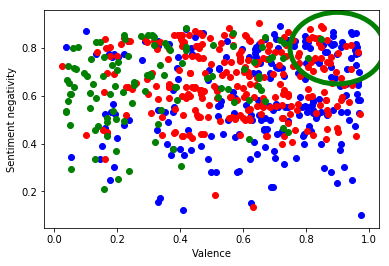

In [288]:
plt.scatter(beatles_df['valence'], beatles_df['neg'], color='blue')
plt.scatter(stones_df['valence'], stones_df['neg'], color='red')
plt.scatter(radiohead_df['valence'], radiohead_df['neg'], color='green')
plt.xlabel('Valence')
plt.ylabel('Sentiment negativity')

ax = plt.gca()
circ = plt.Circle((0.9, 0.8), radius=0.15, color='g', fill=False, linewidth=5)
ax.add_patch(circ)

plt.show()

In [289]:
results[(results['valence'] > 0.8) & (results['neg'] > 0.7)]

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom
13,57n1teNb2tkcfiYagPmUWr,The Beatles,0.885556,Two Of Us - Remastered,0.711080,0.931,0.300437,0.130952
21,4311wT21Et0q3vepFwXjTu,The Beatles,0.718556,One After 909 - Remastered,0.865737,0.888,0.242043,0.147219
35,67jL5ZAf8hNsRZrfBHNuBT,The Beatles,1.277562,Mean Mr Mustard - Remastered,0.700631,0.970,0.437509,0.161703
43,0htnXrZwJvLllryAQU22JT,The Beatles,0.591707,Only A Northern Song - Remastered,0.735840,0.801,0.197689,0.152564
60,3OSi8ehmSWLTD5KatlzX8r,The Beatles,0.733338,Don't Pass Me By - Remastered,0.857831,0.946,0.247212,0.126358
61,4zExFATo8xg8qFfR4H1ZAn,The Beatles,1.364176,Why Don't We Do It In The Road? - Remastered,0.793242,0.957,0.467795,0.196980
82,7c76SiAfT7JkMiCm8BBCcP,The Beatles,1.139628,"Hello, Goodbye - Remastered 2009",0.827139,0.806,0.389278,0.220234
101,77f3aNeabAbOaSB32Sd5QE,The Beatles,1.620131,Eleanor Rigby - Remastered,0.799326,0.813,0.557293,0.264123
135,67tvBtAhsfHBFpuqJ13ZUq,The Beatles,0.931018,Act Naturally - Remastered,0.756947,0.944,0.316334,0.138867
137,1k9tpndMDRwLkNt67Dlg02,The Beatles,1.408837,You Like Me Too Much - Remastered,0.773406,0.899,0.483411,0.213024


That's interesting. This list contains a lot of the Beatles' most well-known songs. Is there something in this?

Let's define "complexity" as the product of valence and negativity, and see which are the most complext songs.

In [290]:
results['complexity'] = results['valence'] * results['neg']
results.sort_values('complexity', ascending=False).head(10)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom,complexity
163,3Aqo28W4LLAolYpN3duVJl,The Beatles,1.349222,I'll Cry Instead - Remastered,0.863772,0.960,0.462566,0.210524,0.829221
154,3EbGioQyKyf4dycuiPOg3k,The Beatles,0.438356,Everybody's Trying To Be My Baby - Remastered,0.866985,0.943,0.144067,0.086846,0.817567
60,3OSi8ehmSWLTD5KatlzX8r,The Beatles,0.733338,Don't Pass Me By - Remastered,0.857831,0.946,0.247212,0.126358,0.811508
181,5IIBY9M2GxHcVja6DA6wsF,The Beatles,1.362221,Please Mister Postman - Remastered,0.815201,0.961,0.467111,0.200786,0.783408
435,0r5d5LmhLQwJVEw0kTEExp,Spice Girls,0.455497,Tell Me Why,0.849970,0.919,0.150060,0.098196,0.781122
183,6xJSJpO6HJwHhu7UaIc8qR,The Beatles,0.585885,Hold Me Tight - Remastered,0.804870,0.963,0.195653,0.093618,0.775090
21,4311wT21Et0q3vepFwXjTu,The Beatles,0.718556,One After 909 - Remastered,0.865737,0.888,0.242043,0.147219,0.768775
481,0YTqcrcpMFZZlH3T91ljsy,The Rolling Stones,0.677053,I Can't Be Satisfied - Top Gear / 1964,0.812405,0.945,0.227531,0.113667,0.767723
61,4zExFATo8xg8qFfR4H1ZAn,The Beatles,1.364176,Why Don't We Do It In The Road? - Remastered,0.793242,0.957,0.467795,0.196980,0.759132
390,4FHhq0QWpLSS6WZnkJnZp1,The Rolling Stones,0.312839,Feel On Baby - Remastered,0.784292,0.966,0.100178,0.054581,0.757626


There's possibly something in it. The most "complex" song has a very upbeat pop tune and very sad lyrics. The others are similarly interesting.

What about the least "complex" songs?

In [291]:
results.sort_values('complexity', ascending=True).head(10)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom,complexity
210,6f6pEjgfTtuRROmJ4a7Gf3,Radiohead,0.393192,The Numbers,0.292008,0.0552,0.128275,0.430532,0.016119
113,0agoaPIy92gPZ6zRhqXarE,The Beatles,0.634931,Tomorrow Never Knows - Remastered,0.343599,0.0534,0.212803,0.409140,0.018348
497,1CEZV1nYaEeqhWz73HKF3g,The Rolling Stones,1.541667,Intro - Live,0.724038,0.0263,0.529857,0.420707,0.019042
213,01ZpFhrMMqKPVCwyqXneVp,Radiohead,0.218723,True Love Waits,0.532206,0.0379,0.067268,0.466591,0.020171
239,53RYTfkLiyZuUZHwJC3Wmm,Radiohead,0.276367,We Suck Young Blood,0.535358,0.0378,0.087425,0.462442,0.020237
212,3cual6JOG286qZJmCxKRAT,Radiohead,0.332577,Tinker Tailor Soldier Sailor Rich Man Poor Man...,0.477322,0.0507,0.107080,0.449380,0.024200
264,0COiZ7ncho2yi4HotbzgPv,Radiohead,0.349157,Motion Picture Soundtrack,0.576808,0.0435,0.112877,0.456821,0.025091
276,75YUnz58ajMo2VIIuUFvOV,Radiohead,0.248061,The Tourist,0.667864,0.0398,0.077527,0.468768,0.026581
255,29yXMFKIrY1fFY4DYBVZCu,Radiohead,0.567416,Life In a Glasshouse,0.605976,0.0497,0.189195,0.442578,0.030117
79,0ttMfoND7IQqFSMVOPkELC,The Beatles,0.799772,Blue Jay Way - Remastered 2009,0.802557,0.0378,0.270442,0.459513,0.030337


Interestingly, all of the "complex" songs are by The Beatles, while most of the least "complex" songs are by Radiohead. How true is that for all songs?

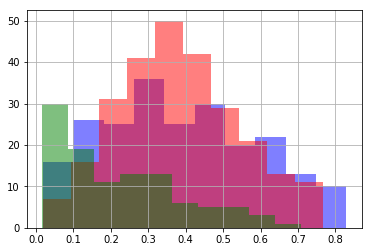

In [292]:
results[results['artist_name'] == 'The Beatles']['complexity'].hist(alpha=0.5, color='blue')
results[results['artist_name'] == 'The Rolling Stones']['complexity'].hist(alpha=0.5, color='red')
results[results['artist_name'] == 'Radiohead']['complexity'].hist(alpha=0.5, color='green')

In [293]:
# Push the results back into the database
for row in results.itertuples():
    unfiltered_tracks.update_one({'_id': row[1]}, {'$set': {'complexity': row.complexity}})

### Average gloom per album<a name="gloomperalbum"></a>
How close can we easily get to the final plot at the end of the fitteR happieR post?

First, we find average gloom per album.

* [Top](#top)

In [294]:
pipeline = [
    {'$match': {'gloom': {'$exists': True}}},
    {'$group': {'_id': '$album.id', 'avg_gloom': {'$avg': '$gloom'}}}]
album_glooms = collections.defaultdict(int, {a['_id']: a['avg_gloom'] for a in tracks.aggregate(pipeline)})
album_glooms

defaultdict(int,
            {'03Qh833fEdVT30Pfs93ea6': 0.24504854934983758,
             '064eFGemsrDcMvgRZ0gqtw': 0.21452555555171524,
             '0PYyrqs9NXtxPhf0CZkq2L': 0.23506412219180753,
             '0ZGddnvcVzHVHfE3WW1tV5': 0.2759842123305305,
             '0aWIIpfY32rT1i3yO9LROl': 0.27338394609475597,
             '19K3IHYeVkUTjcBHGfbCOi': 0.22146657790197213,
             '19RUXBFyM4PpmrLRdtqWbp': 0.34123914793205096,
             '1DBkJIEoeHrTX4WCBQGcCi': 0.2804468995897004,
             '1PULmKbHeOqlkIwcDMNwD4': 0.2262582630601231,
             '1WSfNoPDPzgyKFN6OSYWUx': 0.25301349538560225,
             '1YvnuYGlblQ5vLnOhaZzpn': 0.19666663896330405,
             '1oW3v5Har9mvXnGk0x4fHm': 0.3124460078426787,
             '25mfHGJNQkluvIqedXHSx3': 0.17990617220181726,
             '2Pqkn9Dq2DFtdfkKAeqgMd': 0.2872466899672893,
             '2b3y5k1DchDACjH5KMlgQv': 0.2990206778922061,
             '2gCp8kyDcL93s4kVP4VMTC': 0.23989132903761987,
             '2pCqZLeavM2BMov

In [295]:
albums_df = pd.DataFrame(list(albums.find({}, ['release_date', 'name', 'artist_name'])))

def try_date(d):
    try:
        return datetime.strptime(d, "%Y-%m-%d")
    except ValueError:
        return datetime.strptime(d, "%Y")

albums_df['release_date'] = albums_df['release_date'].apply(lambda d: try_date(d))
albums_df['gloom'] = albums_df['_id'].apply(lambda i: album_glooms[i])
albums_df.sort_values('release_date', inplace=True)
albums_df

,_id,artist_name,name,release_date,gloom
15,7gDXyW16byCQOgK965BRzn,The Beatles,Please Please Me (Remastered),1963-03-22,0.184434
14,3nkEsxmIX0zRNXGAexaHAn,The Beatles,With The Beatles (Remastered),1963-11-22,0.151891
12,71Mwd9tntFQYUk4k2DwA0D,The Beatles,A Hard Day's Night (Remastered),1964-07-10,0.216281
11,7BgGBZndAvDlKOcwe5rscZ,The Beatles,Beatles For Sale (Remastered),1964-12-04,0.176134
10,19K3IHYeVkUTjcBHGfbCOi,The Beatles,Help! (Remastered),1965-08-06,0.221467
9,3OdI6e43crvyAHhaqpxSyz,The Beatles,Rubber Soul (Remastered),1965-12-03,0.212529
8,0PYyrqs9NXtxPhf0CZkq2L,The Beatles,Revolver (Remastered),1966-08-05,0.235064
7,1PULmKbHeOqlkIwcDMNwD4,The Beatles,Sgt. Pepper's Lonely Hearts Club Band (Remaste...,1967-06-01,0.226258
51,3LXItxKnnJcEDc5QdTc00n,The Beatles,Sgt. Pepper's Lonely Hearts Club Band (Deluxe ...,1967-06-01,0.274175
6,6P9yO0ukhOx3dvmhGKeYoC,The Beatles,Magical Mystery Tour (Remastered),1967-11-27,0.266163


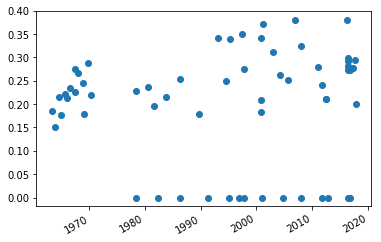

In [296]:
fig, ax = plt.subplots()
ax.plot_date(albums_df['release_date'], albums_df['gloom'])

fig.autofmt_xdate()
plt.show()

One thing that's noticable is the split in time between the groups, and the much shorter period the Beatles were active for.

In [297]:
beatles_df = albums_df[  (albums_df['artist_name'] == 'The Beatles') 
                       & (albums_df['gloom'] > 0) 
                       & (albums_df['release_date'] < datetime(1971, 1, 1))]
beatles_df

,_id,artist_name,name,release_date,gloom
15,7gDXyW16byCQOgK965BRzn,The Beatles,Please Please Me (Remastered),1963-03-22,0.184434
14,3nkEsxmIX0zRNXGAexaHAn,The Beatles,With The Beatles (Remastered),1963-11-22,0.151891
12,71Mwd9tntFQYUk4k2DwA0D,The Beatles,A Hard Day's Night (Remastered),1964-07-10,0.216281
11,7BgGBZndAvDlKOcwe5rscZ,The Beatles,Beatles For Sale (Remastered),1964-12-04,0.176134
10,19K3IHYeVkUTjcBHGfbCOi,The Beatles,Help! (Remastered),1965-08-06,0.221467
9,3OdI6e43crvyAHhaqpxSyz,The Beatles,Rubber Soul (Remastered),1965-12-03,0.212529
8,0PYyrqs9NXtxPhf0CZkq2L,The Beatles,Revolver (Remastered),1966-08-05,0.235064
7,1PULmKbHeOqlkIwcDMNwD4,The Beatles,Sgt. Pepper's Lonely Hearts Club Band (Remaste...,1967-06-01,0.226258
51,3LXItxKnnJcEDc5QdTc00n,The Beatles,Sgt. Pepper's Lonely Hearts Club Band (Deluxe ...,1967-06-01,0.274175
6,6P9yO0ukhOx3dvmhGKeYoC,The Beatles,Magical Mystery Tour (Remastered),1967-11-27,0.266163


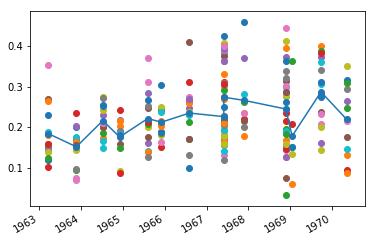

In [298]:
fig, ax = plt.subplots()
ax.plot_date(beatles_df['release_date'].values, beatles_df['gloom'].values, linestyle='-')

fig.autofmt_xdate()

for a in beatles_df.itertuples():
    for t in tracks.find({'album.id': a[1], 'gloom': {'$exists': True}}):
        ax.scatter(a.release_date, t['gloom'])

plt.show()

In [299]:
stones_df = albums_df[(albums_df['artist_name'] == 'The Rolling Stones') & (albums_df['gloom'] > 0)]
stones_df

,_id,artist_name,name,release_date,gloom
47,6FjXxl9VLURGuubdXUn2J3,The Rolling Stones,Some Girls (Deluxe Version),1978-06-09,0.227614
45,2wZgoXS06wSdu9C0ZJOvlc,The Rolling Stones,Emotional Rescue (2009 Re-Mastered),1980-06-20,0.236002
44,1YvnuYGlblQ5vLnOhaZzpn,The Rolling Stones,Tattoo You (2009 Re-Mastered),1981-08-24,0.196667
42,064eFGemsrDcMvgRZ0gqtw,The Rolling Stones,Undercover (2009 Re-Mastered),1983-11-07,0.214526
41,1WSfNoPDPzgyKFN6OSYWUx,The Rolling Stones,Dirty Work (Remastered 2009),1986-03-24,0.253013
39,25mfHGJNQkluvIqedXHSx3,The Rolling Stones,Steel Wheels (2009 Re-Mastered),1989-08-29,0.179906
37,62ZT16LY1phGM0O8x5qW1z,The Rolling Stones,Voodoo Lounge (Remastered 2009),1994-07-11,0.250556
35,0ZGddnvcVzHVHfE3WW1tV5,The Rolling Stones,Bridges To Babylon (Remastered),1997-09-29,0.275984
33,4FTHynKEtuP7eppERNfjyG,The Rolling Stones,A Bigger Bang (2009 Re-Mastered),2005-09-05,0.252222
61,2gCp8kyDcL93s4kVP4VMTC,The Rolling Stones,Some Girls: Live In Texas '78,2011-11-21,0.239891


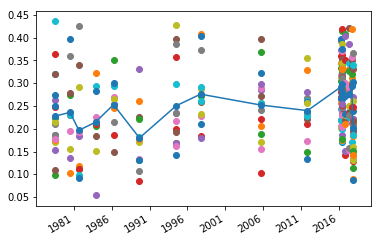

In [300]:
fig, ax = plt.subplots()
ax.plot_date(stones_df['release_date'].values, stones_df['gloom'].values, linestyle='-')

for a in stones_df.itertuples():
    for t in tracks.find({'album.id': a[1], 'gloom': {'$exists': True}}):
        ax.scatter(a.release_date, t['gloom'])

fig.autofmt_xdate()
plt.show()

In [301]:
radiohead_df = albums_df[(albums_df['artist_name'] == 'Radiohead') & (albums_df['gloom'] > 0)]
radiohead_df

,_id,artist_name,name,release_date,gloom
27,6400dnyeDyD2mIFHfkwHXN,Radiohead,Pablo Honey,1993-02-22,0.342392
26,500FEaUzn8lN9zWFyZG5C2,Radiohead,The Bends,1995-03-28,0.340483
25,7dxKtc08dYeRVHt3p9CZJn,Radiohead,OK Computer,1997-05-28,0.350469
24,19RUXBFyM4PpmrLRdtqWbp,Radiohead,Kid A,2000-10-01,0.341239
23,6V9YnBmFjWmXCBaUVRCVXP,Radiohead,Amnesiac,2001-03-12,0.372214
21,1oW3v5Har9mvXnGk0x4fHm,Radiohead,Hail To the Thief,2003-01-01,0.312446
20,6Eo5EkmdLvZrONzi046iC2,Radiohead,Com Lag: 2+2=5,2004-03-24,0.262193
19,36lJLPoPPOKNFddTAcirnc,Radiohead,In Rainbows Disk 2,2007-01-01,0.380068
18,7eyQXxuf2nGj9d2367Gi5f,Radiohead,In Rainbows,2007-12-28,0.323648
13,1DBkJIEoeHrTX4WCBQGcCi,Radiohead,The King Of Limbs,2011-02-18,0.280447


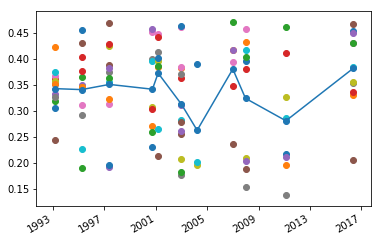

In [302]:
fig, ax = plt.subplots()
ax.plot_date(radiohead_df['release_date'].values, radiohead_df['gloom'].values, linestyle='-')

for a in radiohead_df.itertuples():
    for t in tracks.find({'album.id': a[1], 'gloom': {'$exists': True}}):
        ax.scatter(a.release_date, t['gloom'])

fig.autofmt_xdate()
plt.show()

## Complexity per album<a name="complexityovertime"></a>
Let's generate the same plots for "complexity" per album.

* [Top](#top)

In [303]:
pipeline = [
    {'$match': {'gloom': {'$exists': True}}},
    {'$group': {'_id': '$album.id', 'avg_complexity': {'$avg': '$complexity'}}}]
album_complexities = collections.defaultdict(int, {a['_id']: a['avg_complexity'] for a in tracks.aggregate(pipeline)})
album_complexities

defaultdict(int,
            {'03Qh833fEdVT30Pfs93ea6': 0.3084131495395589,
             '064eFGemsrDcMvgRZ0gqtw': 0.4930224271112733,
             '0PYyrqs9NXtxPhf0CZkq2L': 0.3973574748657116,
             '0ZGddnvcVzHVHfE3WW1tV5': 0.3476089167176396,
             '0aWIIpfY32rT1i3yO9LROl': 0.2808487462442757,
             '19K3IHYeVkUTjcBHGfbCOi': 0.49631836159501724,
             '19RUXBFyM4PpmrLRdtqWbp': 0.19854806544129924,
             '1DBkJIEoeHrTX4WCBQGcCi': 0.2386589222850704,
             '1PULmKbHeOqlkIwcDMNwD4': 0.33583806070307276,
             '1WSfNoPDPzgyKFN6OSYWUx': 0.40386775201828523,
             '1YvnuYGlblQ5vLnOhaZzpn': 0.4516868972238403,
             '1oW3v5Har9mvXnGk0x4fHm': 0.3027634317483144,
             '25mfHGJNQkluvIqedXHSx3': 0.45746084225123357,
             '2Pqkn9Dq2DFtdfkKAeqgMd': 0.2836235772811999,
             '2b3y5k1DchDACjH5KMlgQv': 0.2620656619335576,
             '2gCp8kyDcL93s4kVP4VMTC': 0.38030471265793914,
             '2pCqZLeavM2BMovJXsJ

In [304]:
albums_df['complexity'] = albums_df['_id'].apply(lambda i: album_complexities[i])
# beatles_df = albums_df[albums_df['release_date'] < datetime(1971, 1, 1)]
beatles_df = albums_df[(albums_df['artist_name'] == 'The Beatles') 
                       & (albums_df['gloom'] > 0)
                       & (albums_df['release_date'] < datetime(1971, 1, 1))]
stones_df = albums_df[(albums_df['artist_name'] == 'The Rolling Stones') & (albums_df['gloom'] > 0)]
radiohead_df = albums_df[(albums_df['artist_name'] == 'Radiohead') & (albums_df['gloom'] > 0)]
albums_df.head()

,_id,artist_name,name,release_date,gloom,complexity
15,7gDXyW16byCQOgK965BRzn,The Beatles,Please Please Me (Remastered),1963-03-22,0.184434,0.469728
14,3nkEsxmIX0zRNXGAexaHAn,The Beatles,With The Beatles (Remastered),1963-11-22,0.151891,0.579543
12,71Mwd9tntFQYUk4k2DwA0D,The Beatles,A Hard Day's Night (Remastered),1964-07-10,0.216281,0.547707
11,7BgGBZndAvDlKOcwe5rscZ,The Beatles,Beatles For Sale (Remastered),1964-12-04,0.176134,0.509486
10,19K3IHYeVkUTjcBHGfbCOi,The Beatles,Help! (Remastered),1965-08-06,0.221467,0.496318


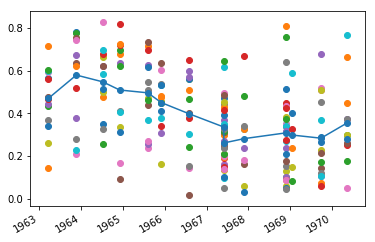

In [305]:
fig, ax = plt.subplots()
ax.plot_date(beatles_df['release_date'].values, beatles_df['complexity'].values, linestyle='-')

fig.autofmt_xdate()

for a in beatles_df.itertuples():
    for t in tracks.find({'album.id': a[1], 'complexity': {'$exists': True}}):
        ax.scatter(a.release_date, t['complexity'])

plt.show()

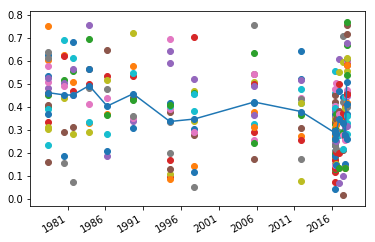

In [306]:
fig, ax = plt.subplots()
ax.plot_date(stones_df['release_date'].values, stones_df['complexity'].values, linestyle='-')

fig.autofmt_xdate()

for a in stones_df.itertuples():
    for t in tracks.find({'album.id': a[1], 'complexity': {'$exists': True}}):
        ax.scatter(a.release_date, t['complexity'])

plt.show()

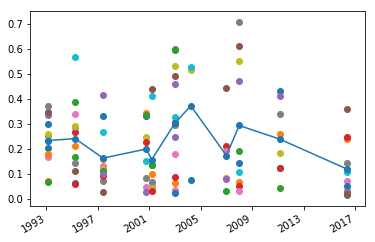

In [307]:
fig, ax = plt.subplots()
ax.plot_date(radiohead_df['release_date'].values, radiohead_df['complexity'].values, linestyle='-')

fig.autofmt_xdate()

for a in radiohead_df.itertuples():
    for t in tracks.find({'album.id': a[1], 'complexity': {'$exists': True}}):
        ax.scatter(a.release_date, t['complexity'])

plt.show()

That isn't what I was expecting. I was expecting the complexity to go up over time, as bands became more adept at contrasting lyrics and melody. It could be because high complexity requires high valence, and bands tend not to become more "poppy" over time.

Let's test that, by also showing the valence of tracks and albums over time.

In [308]:
pipeline = [
    {'$match': {'valence': {'$exists': True}}},
    {'$group': {'_id': '$album.id', 'avg_valence': {'$avg': '$valence'}}}]
album_valences = collections.defaultdict(int, {a['_id']: a['avg_valence'] for a in tracks.aggregate(pipeline)})
albums_df['valence'] = albums_df['_id'].apply(lambda i: album_valences[i])
# beatles_df = albums_df[albums_df['release_date'] < datetime(1971, 1, 1)]
beatles_df = albums_df[(albums_df['artist_name'] == 'The Beatles') 
                       & (albums_df['valence'] > 0)
                       & (albums_df['release_date'] < datetime(1971, 1, 1))]
stones_df = albums_df[(albums_df['artist_name'] == 'The Rolling Stones') 
                         & (albums_df['valence'] > 0)]
radiohead_df = albums_df[(albums_df['artist_name'] == 'Radiohead') 
                         & (albums_df['valence'] > 0)]

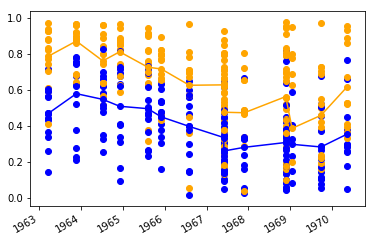

In [309]:
fig, ax = plt.subplots()
ax.plot_date(beatles_df['release_date'].values, beatles_df['complexity'].values, linestyle='-', color='blue')
ax.plot_date(beatles_df['release_date'].values, beatles_df['valence'].values, linestyle='-', color='orange')

fig.autofmt_xdate()

for a in beatles_df.itertuples():
    for t in tracks.find({'album.id': a[1], 'complexity': {'$exists': True}}):
        ax.scatter(a.release_date, t['complexity'], color='blue')
        ax.scatter(a.release_date, t['valence'], color='orange')

plt.show()

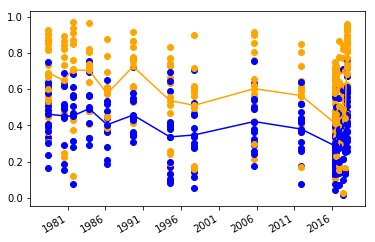

In [310]:
fig, ax = plt.subplots()
ax.plot_date(stones_df['release_date'].values, stones_df['complexity'].values, linestyle='-', color='blue')
ax.plot_date(stones_df['release_date'].values, stones_df['valence'].values, linestyle='-', color='orange')

fig.autofmt_xdate()

for a in stones_df.itertuples():
    for t in tracks.find({'album.id': a[1], 'complexity': {'$exists': True}}):
        ax.scatter(a.release_date, t['complexity'], color='blue')
        ax.scatter(a.release_date, t['valence'], color='orange')

plt.show()

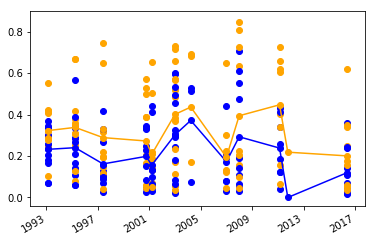

In [311]:
fig, ax = plt.subplots()
ax.plot_date(radiohead_df['release_date'].values, radiohead_df['complexity'].values, linestyle='-', color='blue')
ax.plot_date(radiohead_df['release_date'].values, radiohead_df['valence'].values, linestyle='-', color='orange')

fig.autofmt_xdate()

for a in radiohead_df.itertuples():
    for t in tracks.find({'album.id': a[1], 'complexity': {'$exists': True}}):
        ax.scatter(a.release_date, t['complexity'], color='blue')
        ax.scatter(a.release_date, t['valence'], color='orange')

plt.show()

It definitely looks like the Beatles changed style over time, with the _White Ablum_ / _Yellow Submarine_ (around 1969) being a glitch in the trend. _Hail to the Thief_ and _Com Lag_ are unusual albums for Radiohead.

# Conclusion<a name="conclusion"></a>
A couple of things have come out of this. 

One is that the original analysis is very sensitive to how the sentiment of lyrics is determined. That means I'm not too confident about the reliability of results from either fitteR-happieR or this notebook.

Another is that the Beatles are undoubtedly better than Radiohead. The happiest Beatles sonds are happier than anything Radiohead have done, and their saddest songs are about as sad as Radiohead. In just about every measure, the Beatles' range of music is larger, and covers, Radiohead's.

QED.

## Next steps
The obvious next step is to analyse a different group. What would Queen or ELO look like? Is Adele more depressing than Radiohead?

Another approach would be to apply some machine learning / data mining techniques, perhaps to train a better sentiment analyser, or to cluster songs into groups. Which songs by different artists are most similar to each other?

* [Top](#top)